In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy

In [2]:
# Make transforms and use data loaders

# We'll use these a lot, so make them variables
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

chosen_transforms = {'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]), 'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]),
}

In [6]:
# Set the directory for the data
data_dir = './TRAIN/'

# Use the image folder function to create datasets
chosen_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),chosen_transforms[x])
                   for x in ['train', 'val']}

In [7]:
# Make iterables with the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(chosen_datasets[x], batch_size=4,
  shuffle=True, num_workers=4)
              for x in ['train', 'val']}

In [8]:
dataset_sizes = {x: len(chosen_datasets[x]) for x in ['train', 'val']}
class_names = chosen_datasets['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# Visualize some images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

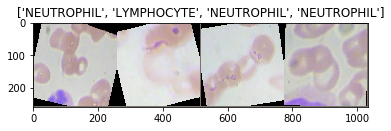

In [12]:
# Grab some of the training data to visualize
inputs, classes = next(iter(dataloaders['train']))

# Now we construct a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [21]:
# Setting up the model
# load in pretrained and reset final fully connected

res_mod = models.resnet34(pretrained=True)

num_ftrs = res_mod.fc.in_features
res_mod.fc = nn.Linear(num_ftrs, 4)

In [22]:
for name, child in res_mod.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [23]:
res_mod = res_mod.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(res_mod.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [24]:
def train_modeltrain_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            print('Iterating through data...')

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients, don't forget it
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)

            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

In [25]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Epoch 0/9
----------
Iterating through data...
train Loss: 0.9389 Acc: 0.6270
Iterating through data...
val Loss: 0.5566 Acc: 0.8494

Epoch 1/9
----------
Iterating through data...
train Loss: 0.5966 Acc: 0.7553
Iterating through data...
val Loss: 0.1685 Acc: 0.9447

Epoch 2/9
----------
Iterating through data...
train Loss: 0.4714 Acc: 0.8101
Iterating through data...
val Loss: 0.1309 Acc: 0.9457

Epoch 3/9
----------
Iterating through data...
train Loss: 0.4076 Acc: 0.8420
Iterating through data...
val Loss: 0.0910 Acc: 0.9590

Epoch 4/9
----------
Iterating through data...
train Loss: 0.3501 Acc: 0.8583
Iterating through data...
val Loss: 0.1406 Acc: 0.9416

Epoch 5/9
----------
Iterating through data...
train Loss: 0.3369 Acc: 0.8613
Iterating through data...
val Loss: 0.0700 Acc: 0.9734

Epoch 6/9
----------
Iterating through data...
train Loss: 0.2600 Acc: 0.8988
Iterating through data...
val Loss: 0.0360 Acc: 0.9887

Epoch 7/9
----------
Iterating through data...
train Loss: 0.2

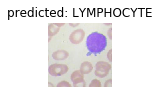

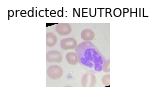

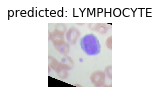

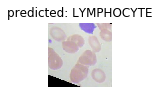

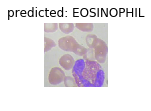

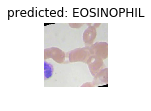

In [26]:
base_model = train_model(res_mod, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)
visualize_model(base_model)
plt.show()

In [46]:
torch.save(base_model,"PATH")

In [47]:
the_model = torch.load("PATH")

In [48]:
the_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [49]:
torch.save(base_model.state_dict(), "model")

In [56]:
base_model.load_state_dict(torch.load("model"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [57]:
the_model_1 = torch.load("model")

In [58]:
the_model_1

OrderedDict([('conv1.weight',
              tensor([[[[ 1.4930e-04, -1.5451e-02,  1.2401e-03,  ...,  4.4026e-02,
                          2.4815e-02,  1.8763e-02],
                        [ 3.5952e-02,  2.1033e-02,  2.1385e-02,  ...,  2.5610e-02,
                          2.2529e-02,  3.3013e-02],
                        [ 3.0930e-03, -3.8986e-02, -6.9915e-02,  ..., -1.0284e-01,
                         -1.2129e-01, -1.2858e-01],
                        ...,
                        [-1.2432e-02, -3.0172e-02, -1.6427e-02,  ...,  1.3313e-02,
                         -8.7754e-04,  1.4474e-02],
                        [ 2.0781e-03, -1.2180e-03,  2.8816e-02,  ...,  9.8919e-02,
                          7.0637e-02,  5.6121e-02],
                        [ 1.6929e-02,  5.2243e-03,  2.6135e-02,  ...,  9.4644e-02,
                          8.3076e-02,  9.5410e-02]],
              
                       [[-3.5587e-03, -9.6639e-03,  1.3442e-02,  ...,  3.2768e-02,
                          2.3307

In [71]:
base_model.class_to_idx = chosen_datasets['train'].class_to_idx
checkpoint = {
              'epochs': 10,
              'batch_size': 4,
              'model':  models.resnet34(pretrained=True),
              'optimizer': optimizer_ft.state_dict(),
              'state_dict': base_model.state_dict(),
              'class_to_idx': base_model.class_to_idx
             }
   
torch.save(checkpoint, 'checkpoint.pth')

In [76]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 4)
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    optimizer = checkpoint['optimizer']
    epochs = checkpoint['epochs']
    
    for param in model.parameters():
        param.requires_grad = False
        
    return model, checkpoint['class_to_idx']
model, class_to_idx = load_checkpoint('checkpoint.pth')

In [77]:
image_size = 224
# Values you used for normalizing the images. Default here are for
# pretrained models from torchvision.
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

In [79]:
# Import resources
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import time
import json
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import PIL
from PIL import Image
from collections import OrderedDict
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F

In [83]:
image_path = './TEST/LYMPHOCYTE/_0_33.jpeg'
img = Image.open(image_path)

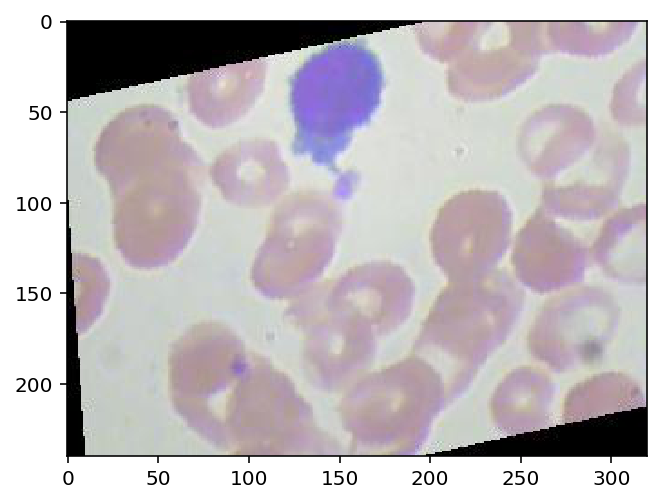

In [113]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # TODO: Process a PIL image for use in a PyTorch model
    # tensor.numpy().transpose(1, 2, 0)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])
    image = preprocess(image)
    return image
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax
with Image.open('./TEST/LYMPHOCYTE/_0_33.jpeg') as image:
    plt.imshow(image)
model.class_to_idx = chosen_datasets['train'].class_to_idx

In [114]:
def predict2(image_path, model, topk=4):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    img = Image.open(image_path)
    img = process_image(img)
    
    # Convert 2D image to 1D vector
    img = np.expand_dims(img, 0)
    
    
    img = torch.from_numpy(img)
    
    model.eval()
    inputs = Variable(img).to(device)
    logits = model.forward(inputs)
    
    ps = F.softmax(logits,dim=1)
    topk = ps.cpu().topk(topk)
    
    return (e.data.numpy().squeeze().tolist() for e in topk)

In [130]:
img_path = './TEST/LYMPHOCYTE/_0_33.jpeg'
cat_to_name    = ['EOSINOPHIL','LYMPHOCYTE','MONOCYTE','NEUTROPHIL']
probs, classes = predict2(img_path, model, topk=4)
print(probs)
print(classes)
blood_types = [[class_names[e]] for e in classes]
print(blood_types)

[0.9999755620956421, 1.8910573999164626e-05, 5.2853160923405085e-06, 2.7830827775687794e-07]
[1, 2, 3, 0]
[['LYMPHOCYTE'], ['MONOCYTE'], ['NEUTROPHIL'], ['EOSINOPHIL']]


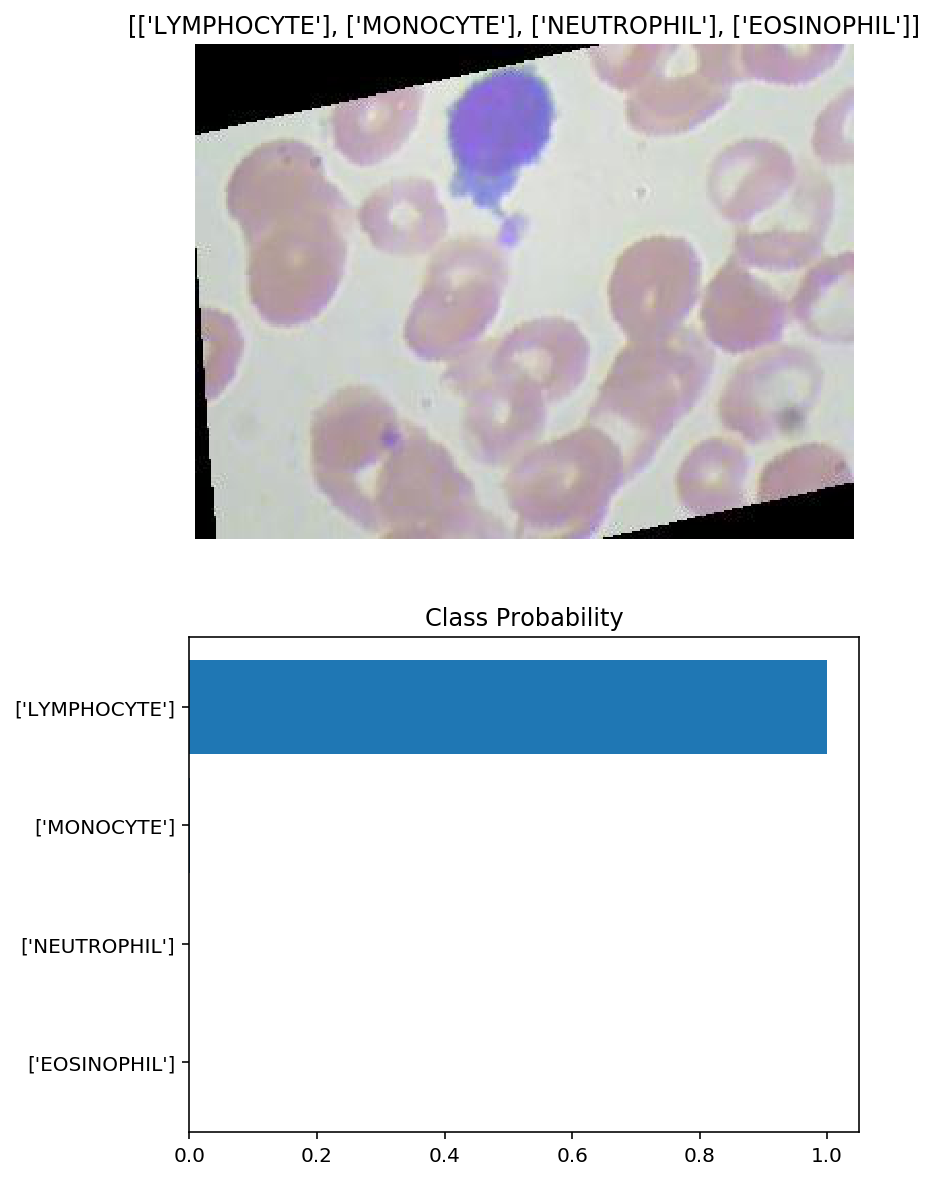

In [138]:
def view_classify(img_path, prob, classes):
    ''' Function for viewing an image and it's predicted classes.
    '''
    image = Image.open(img_path)
    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
    blood_name =[img_path.split('/')[-2]]
    ax1.set_title(blood_types)
    ax1.imshow(image)
    ax1.axis('off')
    
    y_pos = np.arange(len(prob))
    ax2.barh(y_pos, prob, align='center')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(blood_types)
    ax2.invert_yaxis()  # labels read top-to-bottom
    ax2.set_title('Class Probability')
view_classify(img_path, probs, classes)    

In [139]:
class_to_idx

{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}

In [140]:
import json
with open('class_to_idx.json', 'w') as f:
    json.dump(class_to_idx, f)